In [1]:
import os
import urllib
from pathlib import Path
from astropy.coordinates import spherical_to_cartesian
from craterdetection.detection.model import DeepMoon
from craterdetection.common.camera import Camera
from craterdetection.common.conics import generate_mask, crater_representation

import spiceypy as spice

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import datetime as dt
from surrender.geometry import look_at, vec3, quat
from craterdetection.common.camera import Camera
from craterdetection.common.surrender import setup_renderer
from craterdetection.common.spice import setup_spice
import craterdetection.common.constants as const
from craterdetection.matching.database import extract_robbins_dataset, load_craters

In [2]:
_BASE_URL = 'https://naif.jpl.nasa.gov/pub/naif/'
_KERNEL_ROOT = Path('../data/spice_kernels')
def download_kernel(file_path, base_url=_BASE_URL, base_folder=_KERNEL_ROOT):
    if isinstance(file_path, str):
        file_path = Path(file_path)

    local_path = base_folder / file_path
    url = base_url + file_path.as_posix()

    # Create necessary sub-directories in the DL_PATH direction
    local_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        # If the file is not present in the download directory -> download it
        if not os.path.isfile(local_path):
            print(f"Downloading {url}", end="  ")
            # Download the file with the urllib  package
            urllib.request.urlretrieve(str(url), str(local_path))
            print("Done.")
        else:
            print(f"{base_folder / file_path} already exists!")
    except urllib.error.HTTPError as e:
        print(f"Error: \n{url} could not be found: ", e)

kernels_ = [
               'generic_kernels/lsk/naif0012.tls',
               'generic_kernels/pck/pck00010.tpc',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/spk/de421.bsp',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/pck/moon_pa_de421_1900_2050.bpc',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_assoc_pa.tf',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_080317.tf'
           ]
kernels = list(map(Path, kernels_))

for k in kernels:
    download_kernel(k)

spice.furnsh(list(map(lambda x: str(_KERNEL_ROOT / x), kernels)))
s = setup_renderer()

..\data\spice_kernels\generic_kernels\lsk\naif0012.tls already exists!
..\data\spice_kernels\generic_kernels\pck\pck00010.tpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\spk\de421.bsp already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\pck\moon_pa_de421_1900_2050.bpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_assoc_pa.tf already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_080317.tf already exists!
Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [3]:
# Constants:
sun_radius = 696342000
earth_radius = 6371e3
ua2km = 149597870.700
ua = ua2km * 1e3
R_moon = 1737.4

s.createBRDF('sun', 'sun.brdf', {})
s.createShape('sun', 'sphere.shp', {'radius': sun_radius})
s.createBody('sun', 'sun', 'sun', [])

s.createBRDF("mate", "mate.brdf", {})
s.createShape("earth_shape", "sphere.shp", {'radius': earth_radius})
s.createBody("earth", "earth_shape", "mate", ["earth.jpg"])

s.createBRDF('hapke', 'hapke.brdf', {})
s.createSphericalDEM('moon', 'FullMoon.dem', 'hapke', 'lroc_color_poles.tiff')
s.setObjectElementBRDF('moon', 'moon', 'hapke')
s.setObjectAttitude('moon', np.array([0, 0, 0, 1]))

s.setObjectPosition('moon', (0, 0, 0))
s.setObjectAttitude('moon', quat(vec3(1, 0, 0), 0))
s.setObjectAttitude('moon', R.from_euler('z', np.pi, degrees=False).as_quat())

date = dt.date(2021, 3, 3)
# print(date.strftime('%Y %b %d %H:%M:%S'))
et     = spice.str2et( str(date) )
sun_pos, _ = spice.spkpos(
    'sun', et, 'iau_moon', 'lt+s', 'moon'
)
earth_pos, _ = spice.spkpos(
    'earth', et, 'iau_moon', 'lt+s', 'moon' )

s.setObjectPosition('earth', earth_pos*1e3)
s.setObjectPosition('sun', sun_pos*1e3)

In [4]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[3, 100], ellipse_limit=1.3)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

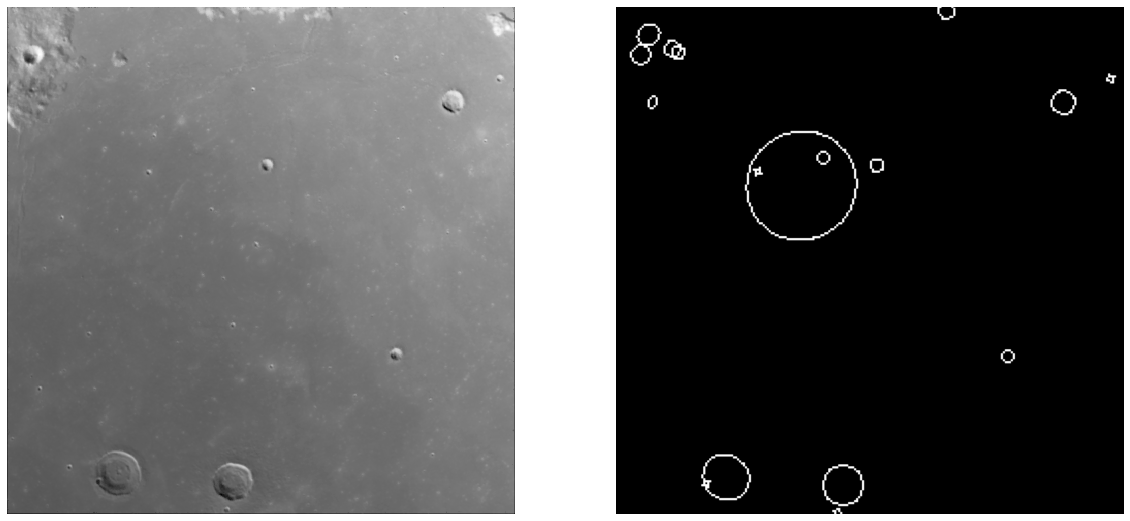

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

cam_alt = 300

for i in range(45):
    cam = Camera.from_coordinates(i, -20, cam_alt, convert_to_radians=True, resolution=(256, 256))

    s.setObjectPosition('camera', cam.r.ravel()*1e3)
    s.setObjectAttitude('camera', R.from_matrix(cam.T).as_quat())

    dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
    vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
    r_craters = r_craters_cat[vicinity]
    C_craters = C_craters_cat[vicinity]
    A_craters = cam.project_crater_conics(C_craters, r_craters)

    s.render()
    im = s.getImageGray32F()

    axes[0].imshow(im, aspect='equal', interpolation='none', cmap='Greys_r', origin='upper')
    axes[0].set_axis_off()

    axes[1].imshow(generate_mask(A_craters, cam.resolution), cmap='Greys_r')
    axes[1].set_axis_off()

    display(fig)

    clear_output(wait=True)
    plt.pause(0.5)